In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split

from bikesharing.ml_logic.model import get_folds, train_test_indices
from bikesharing.interface.main import *
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from sklearn.linear_model import LinearRegression

from bikesharing.params import *

In [76]:
X = pd.read_csv(f'{LOCAL_DATA_PATH}/processed/X_processed_from_2019_to_2022.csv').drop(columns='Unnamed: 0')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   is_holiday            35040 non-null  int64  
 1   is_weekend            35040 non-null  int64  
 2   temperature_2m        35040 non-null  float64
 3   apparent_temperature  35040 non-null  float64
 4   windspeed_10m         35040 non-null  float64
 5   precipitation         35040 non-null  float64
 6   hour_sin              35040 non-null  float64
 7   hour_cos              35040 non-null  float64
 8   month_sin             35040 non-null  float64
 9   month_cos             35040 non-null  float64
 10  day_sin               35040 non-null  float64
 11  day_cos               35040 non-null  float64
 12  weekday_sin           35040 non-null  float64
 13  weekday_cos           35040 non-null  float64
dtypes: float64(12), int64(2)
memory usage: 3.7 MB


In [77]:
y = pd.read_csv(f'{LOCAL_DATA_PATH}/processed/y_processed_from_2019_to_2022.csv')
y.head()

,Altstadt-Lehel,Au - Haidhausen,Aubing-Lochhausen-Langwied,Berg am Laim,Bogenhausen,Feldmoching,Hadern,Harlaching,Hasenbergl-Lerchenau Ost,Laim,...,Schwanthalerhöhe,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [195]:
y.mean(axis=0)

Altstadt-Lehel                  3.299695
Au - Haidhausen                 1.733102
Aubing-Lochhausen-Langwied      0.139716
Berg am Laim                    0.585757
Bogenhausen                     1.172242
Feldmoching                     0.027849
Hadern                          0.291538
Harlaching                      0.108074
Hasenbergl-Lerchenau Ost        0.055270
Laim                            0.778206
Lochhausen                      0.006260
Ludwigsvorstadt-Isarvorstadt    3.750185
Maxvorstadt                     5.497604
Milbertshofen-Am Hart           1.924524
Moosach                         1.002182
Neuhausen-Nymphenburg           3.080866
Obergiesing                     0.759098
Obermenzing                     0.037831
Obersendling                    0.163872
Pasing                          0.176734
Pasing-Obermenzing              0.258827
Ramersdorf-Perlach              0.590221
Schwabing-Freimann              3.558664
Schwabing-West                  2.701375
Schwanthalerhöhe

In [78]:
districts = y.columns

In [79]:
data = pd.concat([X,y] , axis=1)
data.shape

(35064, 48)

# Base XGBoost

In [148]:
fold_dfs = get_folds(data, fold_length=8760, fold_stride=8760)

In [190]:
models = []
districts_rmsle = []
districts_r2 = []
districts_rmse = []

for dist in districts:
    scores_list = []
    scores_r2_list = []
    scores_rmse_list = []

    indices = [0, 1, 2, 3]
        
    for id in range(4):
        xgb_r = XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123)

        test_df = fold_dfs[id]
        train_folds = [fold_dfs[i] for i in indices if i != id]
        
        train_df = pd.concat(train_folds, axis=0)
        X_test = test_df.drop(columns= districts)
        y_test = test_df[dist]
        X_train = train_df.drop(columns= districts)
        y_train = train_df[dist]
        
        xgb_r.fit(X_train, y_train)
        y_pred = [x if x >= 0 else 0 for x in xgb_r.predict(X_test)]
        score_r2 = r2_score(y_test , y_pred)
        scores = np.sqrt(mean_squared_log_error(y_test, y_pred))
        mse = mean_squared_error(y_test, y_pred)
        
        scores_list.append(scores)
        scores_r2_list.append(score_r2)
        scores_rmse_list.append(np.sqrt(mse))
    
    print(f"{id} >>> scores={scores_list}")
            
    scores_array = np.array(scores)
    districts_rmsle.append(np.mean(scores_array.flatten()))
    districts_r2.append(np.mean(scores_r2_list))
    districts_rmse.append(np.mean(scores_rmse_list))

3 >>> scores=[0.6948430862478344, 0.7044422139367861, 0.6539135274723068, 0.6148105311021876]
3 >>> scores=[0.6443180591133031, 0.6055002574764368, 0.5548243778582697, 0.559221902375291]
3 >>> scores=[0.38692502635497633, 0.416611232235011, 0.3429342284162273, 0.36243164960296265]
3 >>> scores=[0.5160135269771761, 0.5090840099727226, 0.5045816681873999, 0.5088709775841839]
3 >>> scores=[0.5703579998054046, 0.5551153147733673, 0.5615253027200858, 0.5638146665678231]
3 >>> scores=[0.17528970264468335, 0.24383191273421023, 0.12906081935664834, 0.13537520227396854]
3 >>> scores=[0.4670390832353918, 0.46254509921299675, 0.4377767063711451, 0.45869457323370255]
3 >>> scores=[0.3132763957420039, 0.3166072805794622, 0.28934779046853387, 0.29916560005847026]
3 >>> scores=[0.2820563191995759, 0.2861022943241078, 0.18826645876809647, 0.1931405187758643]
3 >>> scores=[0.5474181517185438, 0.53586004975258, 0.5330731089169465, 0.540814516977888]
3 >>> scores=[0.10033511209401016, 0.09934436217975773

In [191]:
metrics_base = pd.DataFrame({'rmsle': districts_rmsle, 'r2': districts_r2, 'rmse': districts_rmse}, index=districts)
metrics_base

,rmsle,r2,rmse
Altstadt-Lehel,0.614811,0.622795,5.225714
Au - Haidhausen,0.559222,0.525842,2.718741
Aubing-Lochhausen-Langwied,0.362432,-2.012317,0.696138
Berg am Laim,0.508871,0.332132,1.303881
Bogenhausen,0.563815,0.480502,2.146151
Feldmoching,0.135375,-0.251632,0.277828
Hadern,0.458695,0.124213,0.960038
Harlaching,0.299166,0.102348,0.537627
Hasenbergl-Lerchenau Ost,0.193141,-0.278926,0.379270
Laim,0.540815,0.355069,1.573335


In [181]:
metrics_round = pd.DataFrame({'rmsle': districts_rmsle, 'r2': districts_r2}, index=districts).sort_values(by='rmsle', ascending=False)
metrics_round

,rmsle,r2
Altstadt-Lehel,0.614811,0.622795
Schwabing-Freimann,0.613741,0.618814
Milbertshofen-Am Hart,0.603144,0.455687
Ludwigsvorstadt-Isarvorstadt,0.596550,0.583185
Moosach,0.570230,0.303737
Maxvorstadt,0.570072,0.641605
Neuhausen-Nymphenburg,0.567564,0.584266
Sendling,0.567234,0.518934
Bogenhausen,0.563815,0.480502
Au - Haidhausen,0.559222,0.525842


In [34]:
merged_metrics = metrics_base.merge(metrics_round, left_index=True, right_index=True, suffixes=('_base', '_round'))

In [37]:
merged_metrics

,rmsle_base,r2_base,rmsle_round,r2_round
Altstadt-Lehel,0.377992,0.622795,0.391723,0.621438
Schwabing-Freimann,0.376678,0.618814,0.389111,0.617277
Milbertshofen-Am Hart,0.363782,0.455687,0.378887,0.451414
Ludwigsvorstadt-Isarvorstadt,0.355871,0.583185,0.363977,0.581672
Moosach,0.325163,0.303737,0.342439,0.286916
Maxvorstadt,0.324982,0.641605,0.329797,0.640736
Neuhausen-Nymphenburg,0.322129,0.584266,0.332173,0.582493
Sendling,0.321754,0.518934,0.337443,0.511965
Bogenhausen,0.317887,0.480502,0.334623,0.470385
Au - Haidhausen,0.312729,0.525842,0.325031,0.519591


<Axes: >

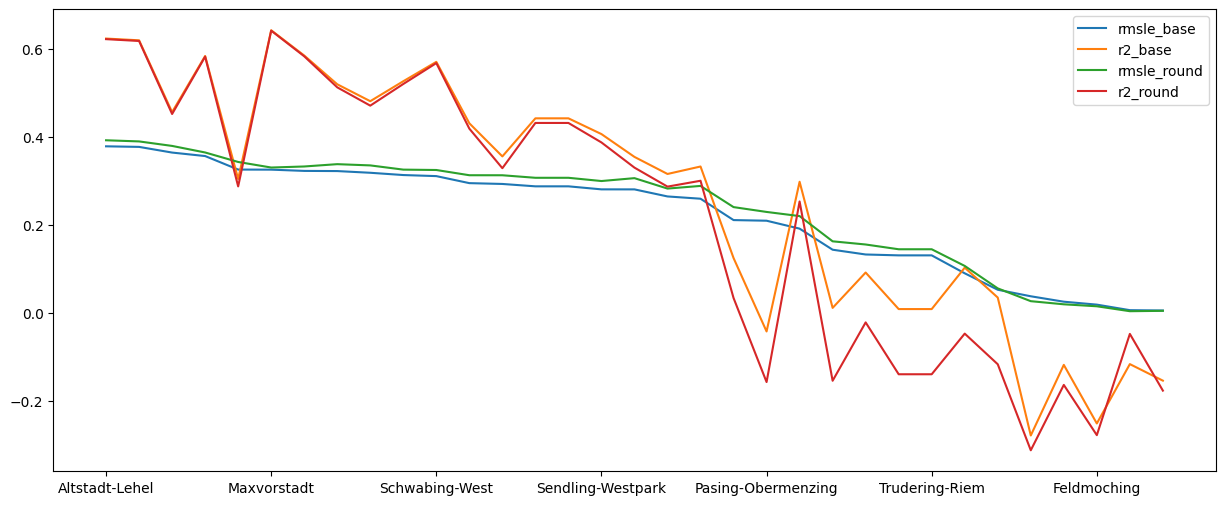

In [40]:
merged_metrics.drop('Aubing-Lochhausen-Langwied', axis=0).plot(figsize=(15,6))

In [37]:
xgb_r = XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123)

test_df = fold_dfs[3]
train_folds = [fold_dfs[i] for i in indices if i != 3]
        
train_df = pd.concat(train_folds, axis=0)
X_test = test_df.drop(columns=districts)
y_test = test_df['Altstadt-Lehel']
X_train = train_df.drop(columns=districts)
y_train = train_df['Altstadt-Lehel']

xgb_r.fit(X_train, y_train)
y_pred = xgb_r.predict(X_test)

Text(0.5, 1.0, 'y_pred')

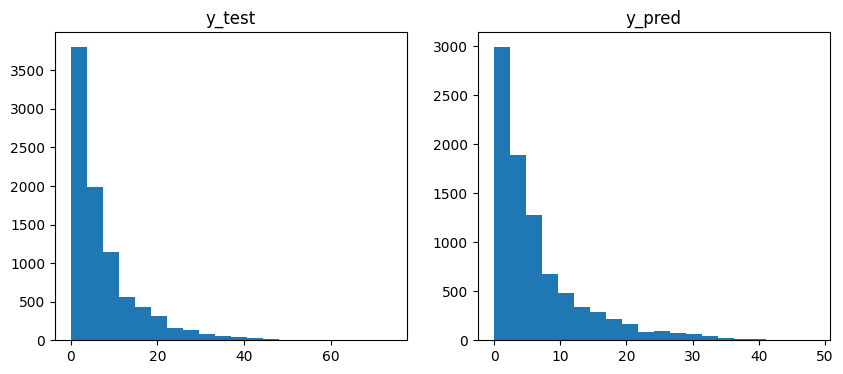

In [62]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(y_test, bins=20)
ax[0].set_title('y_test')
ax[1].hist(y_pred, bins=20)
ax[1].set_title('y_pred')

list

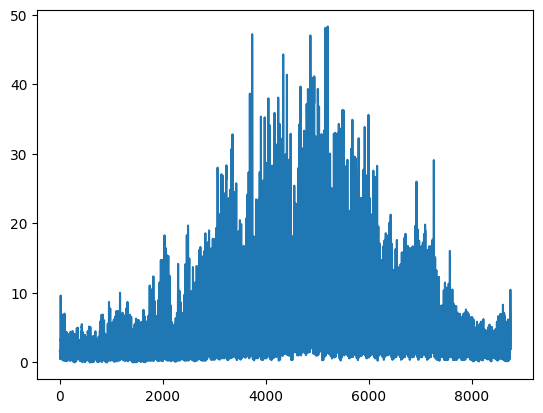

In [40]:
plt.plot(y_pred)

In [66]:
from sklearn.preprocessing import KBinsDiscretizer

est = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
y_test_bins = est.fit_transform(pd.DataFrame(y_test))
y_pred_bins = est.transform(pd.DataFrame(y_pred))

/home/sandra/.pyenv/versions/3.10.6/envs/bike_sharing_demand/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KBinsDiscretizer was fitted with feature names
  warnings.warn(


In [67]:
mean_squared_log_error(y_test_bins, y_pred_bins)

0.2158114378717189

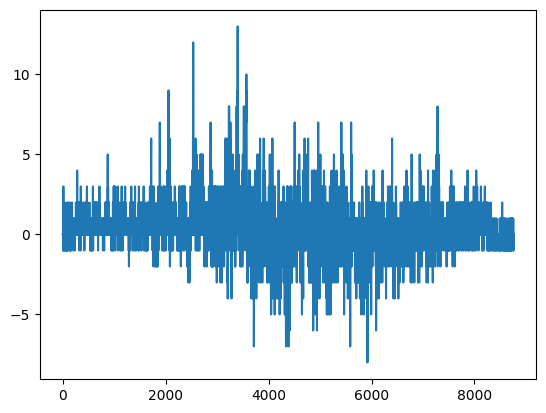

In [82]:
residuals = y_test_bins-y_pred_bins
plt.plot(residuals);

In [83]:
est.bin_edges_

array([array([ 0. ,  3.7,  7.4, 11.1, 14.8, 18.5, 22.2, 25.9, 29.6, 33.3, 37. ,
              40.7, 44.4, 48.1, 51.8, 55.5, 59.2, 62.9, 66.6, 70.3, 74. ])     ],
      dtype=object)

In [94]:
y.describe()

,Altstadt-Lehel,Au - Haidhausen,Aubing-Lochhausen-Langwied,Berg am Laim,Bogenhausen,Feldmoching,Hadern,Harlaching,Hasenbergl-Lerchenau Ost,Laim,...,Schwanthalerhöhe,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,...,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,6.599390,3.466205,0.279432,1.171515,2.344484,0.055698,0.583077,0.216148,0.110541,1.556411,...,1.982090,3.101044,1.547313,0.123403,0.606063,0.323266,0.323266,1.808122,1.808122,0.019336
std,8.541564,3.959244,0.711903,1.600599,3.001915,0.293199,1.068778,0.570971,0.392132,1.979982,...,2.438443,3.909491,2.101708,0.390364,1.268230,0.755566,0.755566,2.480779,2.480779,0.156875
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,9.000000,5.000000,0.000000,2.000000,3.000000,0.000000,1.000000,0.000000,0.000000,2.000000,...,3.000000,4.000000,2.000000,0.000000,1.000000,0.000000,0.000000,3.000000,3.000000,0.000000
max,75.000000,35.000000,10.000000,14.000000,39.000000,7.000000,15.000000,8.000000,9.000000,24.000000,...,23.000000,37.000000,18.000000,6.000000,26.000000,12.000000,12.000000,24.000000,24.000000,6.000000


In [96]:
pd.DataFrame(y.describe().loc['max'], index=districts).sort_values(by='max', ascending=False)

,max
Milbertshofen-Am Hart,121.0
Maxvorstadt,92.0
Schwabing-Freimann,81.0
Altstadt-Lehel,75.0
Ludwigsvorstadt-Isarvorstadt,72.0
Neuhausen-Nymphenburg,64.0
Schwabing-West,55.0
Bogenhausen,39.0
Sendling,37.0
Au - Haidhausen,35.0


In [98]:
r2_score(y_test, y_pred)

0.6084474886740192

In [99]:
X.head()

,is_holiday,is_weekend,temperature_2m,apparent_temperature,windspeed_10m,precipitation,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos
0,1,0,0.355408,0.342007,0.227848,0.017391,0.629410,0.982963,0.75,0.933013,0.600779,0.989739,1.0,0.356896
1,1,0,0.357616,0.340149,0.245570,0.008696,0.750000,0.933013,0.75,0.933013,0.600779,0.989739,1.0,0.356896
2,1,0,0.359823,0.336431,0.303797,0.017391,0.853553,0.853553,0.75,0.933013,0.600779,0.989739,1.0,0.356896
3,1,0,0.359823,0.332714,0.341772,0.008696,0.933013,0.750000,0.75,0.933013,0.600779,0.989739,1.0,0.356896
4,1,0,0.359823,0.332714,0.356962,0.000000,0.982963,0.629410,0.75,0.933013,0.600779,0.989739,1.0,0.356896


In [112]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(y.T)

/home/sandra/.pyenv/versions/3.10.6/envs/bike_sharing_demand/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5)

In [113]:
pd.DataFrame({'labels':kmeans.labels_}, index=y.columns).sort_values(by='labels')

,labels
Untermenzing-Allach,0
Pasing,0
Pasing-Obermenzing,0
Ramersdorf-Perlach,0
Südgiesing,0
Lochhausen,0
Thalkirchen,0
Obersendling,0
Hasenbergl-Lerchenau Ost,0
Hadern,0


# Baseline Linear Regression

In [192]:
models = []
districts_rmsle = []
districts_r2 = []
districts_rmse = []

for dist in districts:
    scores_list = []
    scores_r2_list = []
    scores_rmse_list = []

    indices = [0, 1, 2, 3]
        
    for id in range(4):
        lr = LinearRegression()
        test_df = fold_dfs[id]
        train_folds = [fold_dfs[i] for i in indices if i != id]
        
        train_df = pd.concat(train_folds, axis=0)
        X_test = test_df.drop(columns= districts)
        y_test = test_df[dist]
        X_train = train_df.drop(columns= districts)
        y_train = train_df[dist]
        
        lr.fit(X_train, y_train)
        y_pred = [x if x >= 0 else 0 for x in lr.predict(X_test)]
        score_r2 = r2_score(y_test , y_pred)
        mse = mean_squared_error(y_test, y_pred)
        scores = np.sqrt(mean_squared_log_error(y_test, y_pred))
        scores_list.append(scores)
        scores_r2_list.append(score_r2)
        scores_rmse_list.append(np.sqrt(mse))
    
    print(f"{id} >>> scores={scores_list}")
            
    scores_array = np.array(scores)
    districts_rmsle.append(np.mean(scores_array.flatten()))
    districts_r2.append(np.mean(scores_r2_list))
    districts_rmse.append(np.mean(scores_rmse_list))

3 >>> scores=[0.857854207934544, 0.9022665356148047, 0.825594545886806, 0.7790684016443297]
3 >>> scores=[0.7550307056276891, 0.7275674425650043, 0.6637262791695585, 0.6789831810953836]
3 >>> scores=[0.3816941840138805, 0.4211069836431087, 0.3393553570710777, 0.3578709633211584]
3 >>> scores=[0.5492485675935646, 0.5495755517656902, 0.5460293291464782, 0.5477505861876213]
3 >>> scores=[0.6478911079186058, 0.644829539311948, 0.6403950398626658, 0.6601973422552081]
3 >>> scores=[0.16829056670687884, 0.24569905423450222, 0.12128715730995679, 0.11988775018641555]
3 >>> scores=[0.49261154823176206, 0.49114987163195156, 0.46379638429560804, 0.48789300118520695]
3 >>> scores=[0.31555160417188616, 0.32460927957145874, 0.29141551463008514, 0.2994613770612771]
3 >>> scores=[0.2815238359124707, 0.2837460457415726, 0.18262764612519228, 0.18217658019253616]
3 >>> scores=[0.5989022672666874, 0.5863626119824262, 0.5841056189436652, 0.5975754667875908]
3 >>> scores=[0.09770120180593864, 0.0978976577708

In [193]:
metrics_lr = pd.DataFrame({'rmsle': districts_rmsle, 'r2': districts_r2, 'rmse': districts_rmse}, index=districts)

In [194]:
metrics_lr_xgb = metrics_base.merge(metrics_lr, left_index=True, right_index=True, suffixes=('_xgb', '_lr'))
metrics_lr_xgb

,rmsle_xgb,r2_xgb,rmse_xgb,rmsle_lr,r2_lr,rmse_lr
Altstadt-Lehel,0.614811,0.622795,5.225714,0.779068,0.498038,6.035888
Au - Haidhausen,0.559222,0.525842,2.718741,0.678983,0.399187,3.060254
Aubing-Lochhausen-Langwied,0.362432,-2.012317,0.696138,0.357871,-1.739909,0.687647
Berg am Laim,0.508871,0.332132,1.303881,0.547751,0.250593,1.381443
Bogenhausen,0.563815,0.480502,2.146151,0.660197,0.363338,2.377070
Feldmoching,0.135375,-0.251632,0.277828,0.119888,-0.079186,0.267939
Hadern,0.458695,0.124213,0.960038,0.487893,0.020995,1.016485
Harlaching,0.299166,0.102348,0.537627,0.299461,0.092434,0.541003
Hasenbergl-Lerchenau Ost,0.193141,-0.278926,0.379270,0.182177,-0.183822,0.371749
Laim,0.540815,0.355069,1.573335,0.597575,0.254256,1.691727


In [207]:
metrics_lr_xgb['relative_rmse_xgb'] = metrics_lr_xgb.rmse_xgb / y.mean(axis=0)
metrics_lr_xgb['relative_rmse_lr'] = metrics_lr_xgb.rmse_lr / y.mean(axis=0)
metrics_lr_xgb.sort_values(by='rmsle_xgb', ascending=False)

,rmsle_xgb,r2_xgb,rmse_xgb,rmsle_lr,r2_lr,rmse_lr,relative_rmse_xgb,relative_rmse_lr
Altstadt-Lehel,0.614811,0.622795,5.225714,0.779068,0.498038,6.035888,0.791848,0.914613
Schwabing-Freimann,0.613741,0.618814,5.270259,0.809243,0.483939,6.154012,0.740483,0.864652
Milbertshofen-Am Hart,0.603144,0.455687,3.595025,0.725346,0.386959,3.824988,0.934004,0.993749
Ludwigsvorstadt-Isarvorstadt,0.596550,0.583185,4.892898,0.759234,0.434825,5.701232,0.652354,0.760127
Moosach,0.570230,0.303737,2.191825,0.655389,0.232006,2.314723,1.093527,1.154842
Maxvorstadt,0.570072,0.641605,6.616566,0.788317,0.505824,7.763829,0.601768,0.706110
Neuhausen-Nymphenburg,0.567564,0.584266,4.251767,0.733112,0.421052,5.018753,0.690028,0.814503
Sendling,0.567234,0.518934,2.703859,0.677080,0.381256,3.067307,0.871919,0.989121
Bogenhausen,0.563815,0.480502,2.146151,0.660197,0.363338,2.377070,0.915404,1.013899
Au - Haidhausen,0.559222,0.525842,2.718741,0.678983,0.399187,3.060254,0.784357,0.882883


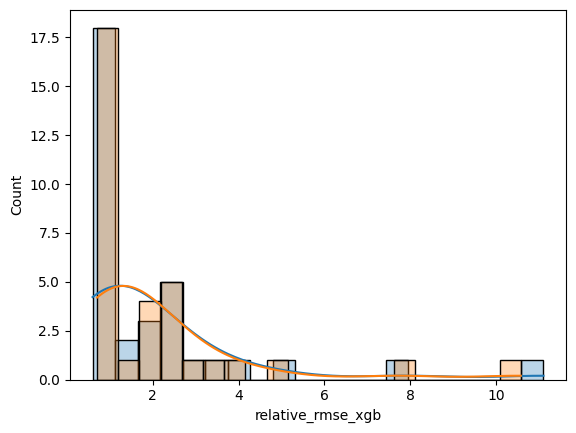

In [205]:
#metrics_lr_xgb[['relative_rmse_xgb', 'relative_rmse_lr']].hist(bins=20, figsize=(15,6))
sns.histplot(x='relative_rmse_xgb', data=metrics_lr_xgb, bins=20, kde=True, alpha=0.3)
sns.histplot(x='relative_rmse_lr', data=metrics_lr_xgb, bins=20, kde=True, alpha=0.3);

In [86]:
metrics_lr_xgb.describe()

,rmsle_xgb,r2_xgb,rmsle_lr,r2_lr
count,34.000000,34.000000,34.000000,34.000000
mean,0.439987,0.196548,0.501728,0.151517
std,0.163504,0.477386,0.221464,0.386398
min,0.070785,-2.012317,0.052432,-1.739909
25%,0.361294,0.008905,0.366165,0.015815
50%,0.521603,0.323647,0.567084,0.245677
75%,0.562666,0.474299,0.672859,0.376777
max,0.614811,0.641605,0.809243,0.505824


In [87]:
metrics_lr_xgb.to_csv(os.path.join(os.path.expanduser('~'), ".lewagon", "bikesharing", "results", "metrics_xgb_vs_lr.csv"), index=True)

<Axes: >

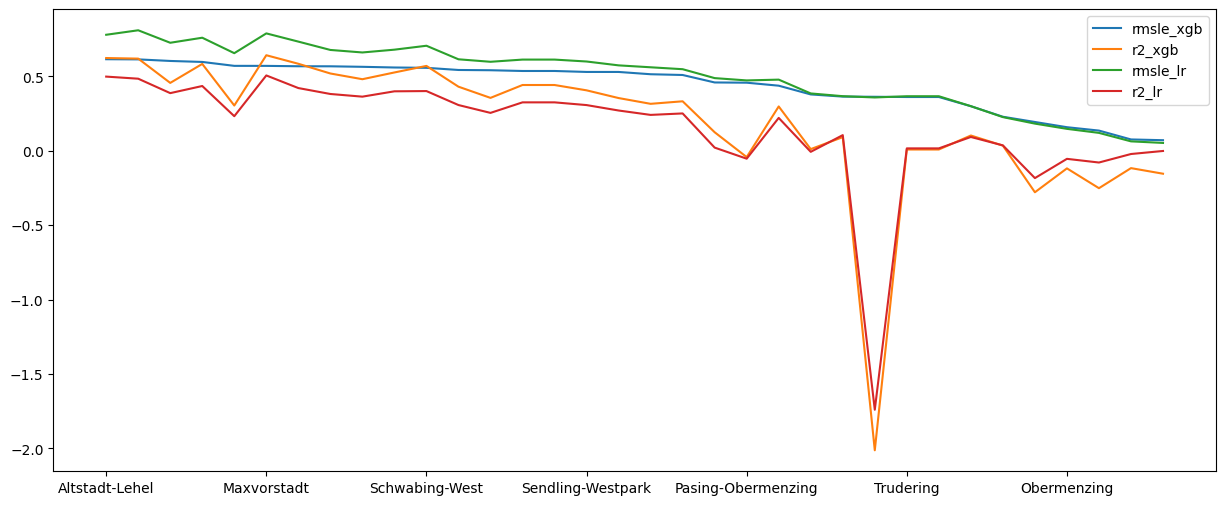

In [88]:
metrics_lr_xgb.plot(figsize=(15,6))

# GridSearch Altstadt

In [59]:
# get folds of 12 months
fold_dfs = get_folds(data, fold_length=8760, fold_stride=8760)

In [98]:
# get X_train & X_test
test_df = fold_dfs[3]    
val_df = fold_dfs[2]   
train_df = pd.concat(fold_dfs[0:3], axis=0)

X_test = test_df.drop(columns=districts)
y_test = test_df['Altstadt-Lehel']
X_val = val_df.drop(columns=districts)
y_val = val_df['Altstadt-Lehel']
X_train = train_df.drop(columns=districts)
y_train = train_df['Altstadt-Lehel']

In [70]:
X_test.shape, y_test.shape, X_val.shape, y_val.shape, X_train.shape, y_train.shape

((8760, 14), (8760,), (8760, 14), (8760,), (26280, 14), (26280,))

In [92]:
np.arange(0.01,0.2, 0.03)

array([0.01, 0.04, 0.07, 0.1 , 0.13, 0.16, 0.19])

In [52]:
from sklearn.metrics import make_scorer

def rmsle(y_true, y_pred):
    return mean_squared_log_error(y_true, np.abs(y_pred))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [167]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit

# Instantiate model
model = XGBRegressor(tree_method = 'approx', objective ='reg:squarederror', seed=1)

# Hyperparameter Grid
grid = {
    'n_estimators':  range(10, 110, 20),
    'eta': [0.01, 0.03, 0.7, 0.1, 0.15, 0.2], 
    'gamma': [0.5, 1, 1.5, 2, 5],
    'max_depth':range(3,10,2),
    'min_child_weight': range(1, 6, 1),
    'max_delta_step': range(0, 10, 2)
}

split_index = [0 if x in X_val.index else -1 for x in X_train.index]
ps = PredefinedSplit(test_fold=split_index)

# Instantiate Grid Search
search = GridSearchCV(
    model,
    grid, 
    scoring = rmsle_scorer,
    cv = ps,
    #cv = 6,
    n_jobs=-1 # parallelize computation
) 

# Fit data to Grid Search
search.fit(X_train, y_train)

KeyboardInterrupt: 

In [68]:
search.best_score_

-0.37957560254214073

In [69]:
search.best_params_

{'eta': 0.01,
 'gamma': 1,
 'max_delta_step': 0,
 'max_depth': 9,
 'min_child_weight': 2,
 'n_estimators': 150}

In [70]:
xgb = search.best_estimator_

In [71]:
y_pred = [round(x) if x >= 0 else 0 for x in xgb.predict(X_test)]
print(f'rmsle: {np.sqrt(mean_squared_log_error(y_test, y_pred))}, r2: {r2_score(y_test , y_pred)}')

rmsle: 0.6322752374461792, r2: 0.550913721119354


In [149]:
rmsle_list = []
r2_list = []

indices = [0, 1, 2, 3]
        
for id in range(4):
    xgb = XGBRegressor(objective ='reg:squarederror',
                n_estimators = 8, seed = 123, tree_method='approx' , gamma=0.5, max_depth=8 , min_child_weight=2,
                max_delta_step = 0)
    test_df = fold_dfs[id]
    train_folds = [fold_dfs[i] for i in indices if i != id]
        
    train_df = pd.concat(train_folds, axis=0)
    X_test = test_df.drop(columns= districts)
    y_test = test_df['Altstadt-Lehel']
    X_train = train_df.drop(columns= districts)
    y_train = train_df['Altstadt-Lehel']
        
    xgb.fit(X_train, y_train)
    y_pred = [x if x >= 0 else 0 for x in xgb.predict(X_test)]
    score_r2 = r2_score(y_test , y_pred)
    scores = np.sqrt(mean_squared_log_error(y_test, y_pred))
        
    rmsle_list.append(scores)
    r2_list.append(score_r2)
    
print(f"rmsle: {rmsle_list} >>> mean: {np.mean(rmsle_list)}")
print(f"r2: {r2_list} >>> mean: {np.mean(r2_list)}")

rmsle: [0.690535995969124, 0.6961300778026763, 0.6294244191420677, 0.6049992490980783] >>> mean: 0.6552724355029866
r2: [0.6033255770055224, 0.6156240868992577, 0.6327116226492924, 0.5993193919514808] >>> mean: 0.6127451696263884


**Default XGBoost & Linear Regression Metrics**

In [102]:
metrics_lr_xgb.loc['Altstadt-Lehel']

rmsle_xgb    0.614811
r2_xgb       0.622795
rmsle_lr     0.779068
r2_lr        0.498038
Name: Altstadt-Lehel, dtype: float64

**Best Score**

In [142]:
xgb_altst = XGBRegressor(objective ='reg:squarederror',
                n_estimators = 8, seed = 123, tree_method='approx' , gamma=0.5, max_depth=8 , min_child_weight=2,
                max_delta_step = 0)
xgb_altst.fit(X_train, y_train)
y_pred =  [round(x) if x >= 0 else 0 for x in xgb_altst.predict(X_test)]
print(f'rmsle: {np.sqrt(mean_squared_log_error(y_test, y_pred))}, r2: {r2_score(y_test , y_pred)}')

rmsle: 0.6171544557669383, r2: 0.5978172877715606


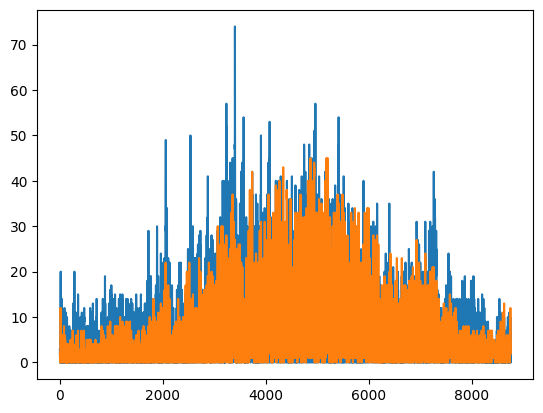

In [100]:
plt.plot(y_test.to_numpy())
#plt.plot(y_train.iloc[8760*2:8760*3].to_numpy())
#plt.plot((y_train.iloc[8760*2:8760*3] - y_pred).to_numpy())
plt.plot(y_pred);

# Finetuning Schwabing-Freimann

In [ ]:
xgb_altst = XGBRegressor(objective ='reg:squarederror',
                n_estimators = 8, seed = 123, tree_method='approx' , gamma=0.5, max_depth=8 , min_child_weight=2,
                max_delta_step = 0)
xgb_altst.fit(X_train, y_train)
y_pred =  [round(x) if x >= 0 else 0 for x in xgb_altst.predict(X_test)]
print(f'rmsle: {np.sqrt(mean_squared_log_error(y_test, y_pred))}, r2: {r2_score(y_test , y_pred)}')

In [166]:
rmsle_list = []
r2_list = []

indices = [0, 1, 2, 3]
        
for id in range(4):
    xgb = XGBRegressor(objective ='reg:squarederror',
                n_estimators = 10, seed = 123 , tree_method='approx' , max_depth=9, min_child_weight=2,
                max_delta_step = 15)
    test_df = fold_dfs[id]
    train_folds = [fold_dfs[i] for i in indices if i != id]
        
    train_df = pd.concat(train_folds, axis=0)
    X_test = test_df.drop(columns= districts)
    y_test = test_df['Schwabing-Freimann']
    X_train = train_df.drop(columns= districts)
    y_train = train_df['Schwabing-Freimann']
        
    xgb.fit(X_train, y_train)
    y_pred = [x if x >= 0 else 0 for x in xgb.predict(X_test)]
    score_r2 = r2_score(y_test , y_pred)
    scores = np.sqrt(mean_squared_log_error(y_test, y_pred))
        
    rmsle_list.append(scores)
    r2_list.append(score_r2)
    
print(f"rmsle: {rmsle_list} >>> mean: {np.mean(rmsle_list)}")
print(f"r2: {r2_list} >>> mean: {np.mean(r2_list)}")

rmsle: [0.6370616121661417, 0.6375467358171928, 0.647821842997412, 0.6057955220429733] >>> mean: 0.6320564282559299
r2: [0.6176617273511109, 0.6109311078016398, 0.5614308352097824, 0.612055258229526] >>> mean: 0.6005197321480148


In [145]:
metrics_lr_xgb.loc['Schwabing-Freimann']

rmsle_xgb    0.613741
r2_xgb       0.618814
rmsle_lr     0.809243
r2_lr        0.483939
Name: Schwabing-Freimann, dtype: float64